# 1. PCA的numpy实现

In [1]:
import numpy as np

x = [2,2,4,8,4]
y = [2,6,6,8,8]
z = [2,4,6,8,10]

# 3个特征(x,y,z) , 5条数据(向量)

S = np.vstack((x,y,z))
print(np.cov(S)) 

[[ 6.  4.  5.]
 [ 4.  6.  7.]
 [ 5.  7. 10.]]


In [2]:
# 中心化(零均质化)
x = x - np.mean(x)
y = y - np.mean(y)
z = z - np.mean(z)

S = np.vstack((x,y,z))

print(S)
print(np.cov(S))
print((1/(5-1) * S.dot(S.T))) # 零均值化后 计算与cov等价 (1/m-1)S·S^T = dim:[3,5] x dim:[5,3]

[[-2. -2.  0.  4.  0.]
 [-4.  0.  0.  2.  2.]
 [-4. -2.  0.  2.  4.]]
[[ 6.  4.  5.]
 [ 4.  6.  7.]
 [ 5.  7. 10.]]
[[ 6.  4.  5.]
 [ 4.  6.  7.]
 [ 5.  7. 10.]]


In [3]:
c = np.array([[6,4,5],
                    [4,6,7],
                    [5,7,10]])

# 计算数据转置的协方差矩阵的特征值和特征向量矩阵Q, 由大到小排列(q1,q2,q3)
evalue, evector = np.linalg.eig(c)
print(evalue)
print('-'*50)
print(evector)

[18.54593442  2.74757971  0.70648587]
--------------------------------------------------
[[ 0.45449308  0.88773369  0.07324579]
 [ 0.54011155 -0.20926298 -0.81516165]
 [ 0.70831883 -0.41004623  0.57458379]]


In [4]:
# 特征向量矩阵Q的转置即为P矩阵, P点乘数据向量矩阵即可得变换后的数据 (u1,u2,u3,u4,u5)
PCA = np.dot(evector.T,S)
print(PCA)

[[-5.90270765 -2.3256238   0.          4.31483305  3.9134984 ]
 [ 0.70176945 -0.95537492  0.          2.31231633 -2.05871086]
 [ 0.81581985 -1.29565917  0.         -0.18817254  0.66801187]]


In [5]:
# 我们希望P映射源数据A后得到的, 新基底下的协方差D为对角阵
# D = 1/(n-1) PA·(PA)^T 
#   = 1/(n-1) P·A·A^T·P^T
#   = 1/(n-1) P·C·P^T

# 根据正定实对称矩阵S必然可以正交分解 S = Q· Λ ·Q^T , 所以Λ = Q^T·S·Q
# 上下对比得到, S = C = A·A^T , Q^T = P

# 对对角化矩阵D进行求解 D = 1/(n-1) Q^T · C · Q , D的对角线即为各新坐标方向上的方差
D = (1 / (len(S[0])-1)) * (evector.T).dot(np.cov(S)).dot(evector)
D

#  1/(n-1) * S的eigenvalue 计算上与 D的对角线代表的方差值 相同。
# 计算累计百分比时是等价的，因此碎石图使用S的特征值作为“方差”。

array([[ 4.63648360e+00,  4.44089210e-16,  6.66133815e-16],
       [ 3.60822483e-16,  6.86894928e-01, -8.32667268e-17],
       [ 6.93889390e-16, -1.38777878e-16,  1.76621467e-01]])

In [6]:
np.round(D,2)

array([[ 4.64,  0.  ,  0.  ],
       [ 0.  ,  0.69, -0.  ],
       [ 0.  , -0.  ,  0.18]])

# 2. PCA的sklearn实现

In [17]:
from sklearn.decomposition import PCA
import pandas as pd

x = [2,2,4,8,4]
y = [2,6,6,8,8]
z = [2,4,6,8,10]

# x = x - np.mean(x)
# y = y - np.mean(y)
# z = z - np.mean(z)

pcs = PCA(n_components=3)
pcs.fit(np.vstack((x,y,z)).T) # 额外多一步.T 从数据向量转为xyz特征列、数据为行
pcs.components_  
# 为何是相反数? -P矩阵 -Q^T
# sklearn中的PCA是通过svd_flip函数实现的，sklearn对奇异值分解结果进行了一个处理，因为ui*σi*vi=(-ui)*σi*(-vi)，也就是u和v同时取反得到的结果是一样的，而这会导致通过PCA降维得到不一样的结果（虽然都是正确的）。
# 为了追求唯一的表示，首先定位ui向量中绝对值最大的元素位置，如果它为负数，则ui和vi取反，否则不变。

array([[-0.45449308, -0.54011155, -0.70831883],
       [ 0.88773369, -0.20926298, -0.41004623],
       [-0.07324579,  0.81516165, -0.57458379]])

           0
0  18.545934
1   2.747580
2   0.706486


Text(0.5, 0, 'principal components')

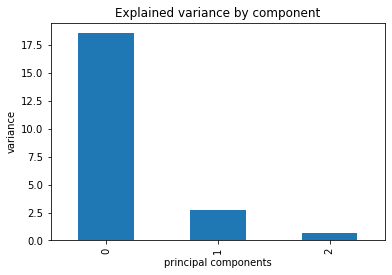

In [18]:
explained_variance = pd.DataFrame(pcs.explained_variance_)
print(explained_variance)
ax = explained_variance.plot.bar(legend=False, title='Explained variance by component')
ax.set_ylabel('variance')
ax.set_xlabel('principal components')

          x         y         z
0 -0.454493 -0.540112 -0.708319
1  0.887734 -0.209263 -0.410046
2 -0.073246  0.815162 -0.574584


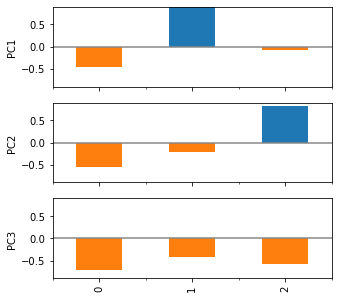

In [19]:
import matplotlib.pyplot as plt
loadings = pd.DataFrame(pcs.components_,columns=['x','y','z'])
print(loadings)
maxPC = 1.01 * np.max(np.max(np.abs(loadings)))
f, axes = plt.subplots(3,1,figsize=(5,5),sharex = True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.iloc[:,i]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color = '#888888')
    pc_loadings.plot.bar(color = colors, ax = ax)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC,maxPC)